#### Этот Ноутбук являетсся Примером/Шаблоном к этому заданию (Baseline) и не служит готовым решением!     
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат. 

# Custom Functions

In [1]:
# Функция подсчета количества выбросов признака
def get_outliers_border(col, lim_bottom=0, lim_top=0, use_limit=False):
    if use_limit:
        return (lim_bottom, lim_top)
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    bottom = Q1 - 1.5*IQR
    top = Q3 + 1.5*IQR

    return (int(bottom), int(top))

# Import

In [2]:
from sklearn import metrics  # инструменты для оценки точности модели
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
# Импортируем необходимые библиотеки:

In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
#!pip freeze > requirements.txt

# DATA

In [5]:
DATA_DIR = './'
data = pd.read_csv(DATA_DIR+'stud_math.csv')

# Чтобы отдельно играть с моделью
data_ml = pd.read_csv(DATA_DIR+'stud_math.csv')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [7]:
pd.set_option('display.max_columns', None)
data.head(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


### Первоначальное описание колонок:
1 **school** — аббревиатура школы, в которой учится ученик;

2 **sex** — пол ученика (**'F'** - женский, **'M'** - мужской);

3 **age** — возраст ученика (от **15** до **22**);

4 **address** — тип адреса ученика (**'U'** - городской, **'R'** - за городом);

5 **famsize** — размер семьи(**'LE3'** <= 3, **'GT3'** >3);

6 **p_status** — статус совместного жилья родителей (**'T'** - живут вместе **'A'** - раздельно);

7 **m_edu** — образование матери (**0** - нет, **1** - 4 класса, **2** - 5-9 классы,
    **3** - среднее специальное или 11 классов, **4** - высшее);

8 **f_edu** — образование отца (**0** - нет, **1** - 4 класса, **2** - 5-9 классы, 
    **3** - среднее специальное или 11 классов, **4** - высшее);

9 **m_job** — работа матери (**'teacher'** - учитель, **'health'** - сфера здравоохранения, 
    **services'** - гос служба, **'at_home'** - не работает, **'other'** - другое);

10 **f_job** — работа отца (**'teacher'** - учитель, **'health'** - сфера здравоохранения, 
    **'services'** - гос служба, **'at_home'** - не работает, **'other'** - другое);

11 **reason** — причина выбора школы (**'home'** - близость к дому, **'reputation'** - репутация школы, 
    **'course'** - образовательная программа, **'other'** - другое);

12 **guardian** — опекун (**'mother'** - мать, **'father'** - отец, **'other'** - другое);

13 **traveltime** — время в пути до школы (**1** - <15 мин., **2** - 15-30 мин., 
    **3** - 30-60 мин., **4** - >60 мин.);

14 **studytime** — время на учёбу помимо школы в неделю (**1** - <2 часов, **2** - 2-5 часов, 
    **3** - 5-10 часов, **4** - >10 часов);

15 **failures** — количество внеучебных неудач (**n**, если 1<=n<3, иначе **4**);

16 **schoolsup** — дополнительная образовательная поддержка (**yes** или **no**);

17 **famsup** — семейная образовательная поддержка (**yes** или **no**);

18 **paid** — дополнительные платные занятия по математике (**yes** или **no**);

19 **activities** — дополнительные внеучебные занятия (**yes** или **no**);

20 **nursery** — посещал детский сад (**yes** или **no**);

**studytime_granular** - неизвестная колонка, необходимо понять, с чем она коррелирует

21 **higher** — хочет получить высшее образование (**yes** или **no**);

22 **internet** — наличие интернета дома (**yes** или **no**);

23 **romantic** — в романтических отношениях (**yes** или **no**);

24 **famrel** — семейные отношения (от **1** - очень плохо до **5** - очень хорошо);

25 **freetime** — свободное время после школы (от **1** - очень мало до **5** - очень мого);

26 **goout** — проведение времени с друзьями (от **1** - очень мало до **5** - очень много);

27 **health_level** — текущее состояние здоровья (от **1** - очень плохо до **5** - очень хорошо);

28 **absences** — количество пропущенных занятий;

29 **score** — баллы по госэкзамену по математике (целевой параметр).

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# 1. EDA  
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками. В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой. 
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

## Анализ признаков
* Строим графики
* Проводим корреляционный анализ
* Находим дублирующиеся признаки
* Находим выбросы
* Cмотрим распределение целевой переменной
* Распределение целевой переменной относительно признаков
* Находим Возможные закономерности и взаимосвязи

## Посмотрим сколько пропущенных значений в данных

In [8]:
# Проверим наличие пропусков в данных
print('Проверяем наличие пропусков в данных')
display(data.isnull().sum())

Проверяем наличие пропусков в данных


school                  0
sex                     0
age                     0
address                17
famsize                27
Pstatus                45
Medu                    3
Fedu                   24
Mjob                   19
Fjob                   36
reason                 17
guardian               31
traveltime             28
studytime               7
failures               22
schoolsup               9
famsup                 39
paid                   40
activities             14
nursery                16
studytime, granular     7
higher                 20
internet               34
romantic               31
famrel                 27
freetime               11
goout                   8
health                 15
absences               12
score                   6
dtype: int64

In [9]:
print(
    f'Всего пропущенных значений во всех признаках: {data.isnull().sum().sum()}')

Всего пропущенных значений во всех признаках: 565


## Закодируем категориальные признаки

In [10]:
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data = pd.get_dummies(data, columns=object_columns, dummy_na=True)

In [11]:
data.head(5)

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score,school_GP,school_MS,school_nan,sex_F,sex_M,sex_nan,address_R,address_U,address_nan,famsize_GT3,famsize_LE3,famsize_nan,Pstatus_A,Pstatus_T,Pstatus_nan,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Mjob_nan,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,Fjob_nan,reason_course,reason_home,reason_other,reason_reputation,reason_nan,guardian_father,guardian_mother,guardian_other,guardian_nan,schoolsup_no,schoolsup_yes,schoolsup_nan,famsup_no,famsup_yes,famsup_nan,paid_no,paid_yes,paid_nan,activities_no,activities_yes,activities_nan,nursery_no,nursery_yes,nursery_nan,higher_no,higher_yes,higher_nan,internet_no,internet_yes,internet_nan,romantic_no,romantic_yes,romantic_nan
0,18,4.0,4.0,2.0,2.0,0.0,-6.0,4.0,3.0,4.0,3.0,6.0,30.0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0,0
1,17,1.0,1.0,1.0,2.0,0.0,-6.0,5.0,3.0,3.0,3.0,4.0,30.0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0
2,15,1.0,1.0,1.0,2.0,3.0,-6.0,4.0,3.0,2.0,3.0,10.0,50.0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1
3,15,4.0,2.0,1.0,3.0,0.0,-9.0,3.0,2.0,2.0,5.0,2.0,75.0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0
4,16,3.0,3.0,1.0,2.0,0.0,-6.0,4.0,3.0,2.0,5.0,4.0,50.0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0


## Обработаем NAN значения

In [12]:
# Заполним пропуски средним значением
nan_columns = list(data.columns[data.isnull().sum() > 0])
if nan_columns:
    for nan_column in nan_columns:
        data[nan_column+'_isNAN'] = pd.isna(data[nan_column]).astype('uint8')
    data.fillna(data.quantile(0.5), inplace=True)

In [13]:
data.head(5)

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score,school_GP,school_MS,school_nan,sex_F,sex_M,sex_nan,address_R,address_U,address_nan,famsize_GT3,famsize_LE3,famsize_nan,Pstatus_A,Pstatus_T,Pstatus_nan,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Mjob_nan,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,Fjob_nan,reason_course,reason_home,reason_other,reason_reputation,reason_nan,guardian_father,guardian_mother,guardian_other,guardian_nan,schoolsup_no,schoolsup_yes,schoolsup_nan,famsup_no,famsup_yes,famsup_nan,paid_no,paid_yes,paid_nan,activities_no,activities_yes,activities_nan,nursery_no,nursery_yes,nursery_nan,higher_no,higher_yes,higher_nan,internet_no,internet_yes,internet_nan,romantic_no,romantic_yes,romantic_nan,Medu_isNAN,Fedu_isNAN,traveltime_isNAN,studytime_isNAN,failures_isNAN,"studytime, granular_isNAN",famrel_isNAN,freetime_isNAN,goout_isNAN,health_isNAN,absences_isNAN,score_isNAN
0,18,4.0,4.0,2.0,2.0,0.0,-6.0,4.0,3.0,4.0,3.0,6.0,30.0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,17,1.0,1.0,1.0,2.0,0.0,-6.0,5.0,3.0,3.0,3.0,4.0,30.0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,15,1.0,1.0,1.0,2.0,3.0,-6.0,4.0,3.0,2.0,3.0,10.0,50.0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,15,4.0,2.0,1.0,3.0,0.0,-9.0,3.0,2.0,2.0,5.0,2.0,75.0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,16,3.0,3.0,1.0,2.0,0.0,-6.0,4.0,3.0,2.0,5.0,4.0,50.0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
data.isnull().sum()

age               0
Medu              0
Fedu              0
traveltime        0
studytime         0
                 ..
freetime_isNAN    0
goout_isNAN       0
health_isNAN      0
absences_isNAN    0
score_isNAN       0
Length: 85, dtype: int64

## Посмотрим распределение целевой переменной

[Text(0, 0.5, 'Количество'), Text(0.5, 0, 'Оценка')]

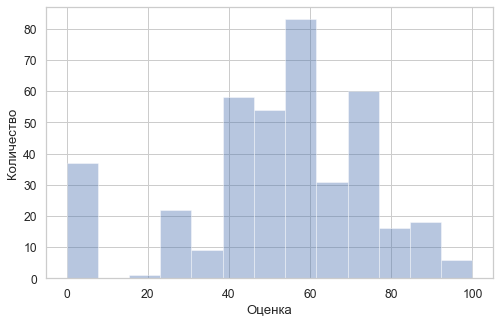

In [15]:
sns.set(style='whitegrid', palette="deep",
        font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(data.score, kde=False, norm_hist=False).set(
    xlabel='Оценка', ylabel='Количество')

Видно, что в целом, целевая переменная распределена нормально с некоторыми значениями в нуле. Посмотрим на эти данные повнимательнее.

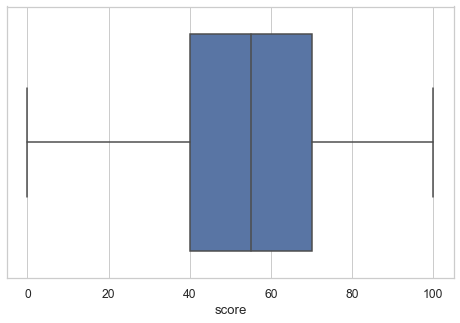

In [16]:
sns.boxplot(x=data.score, data=data)

In [17]:
print('Данные с нулевыми значениями целевой переменной')
display(data[data.score == 0].head(10))

Данные с нулевыми значениями целевой переменной


,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score,school_GP,school_MS,school_nan,sex_F,sex_M,sex_nan,address_R,address_U,address_nan,famsize_GT3,famsize_LE3,famsize_nan,Pstatus_A,Pstatus_T,Pstatus_nan,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Mjob_nan,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,Fjob_nan,reason_course,reason_home,reason_other,reason_reputation,reason_nan,guardian_father,guardian_mother,guardian_other,guardian_nan,schoolsup_no,schoolsup_yes,schoolsup_nan,famsup_no,famsup_yes,famsup_nan,paid_no,paid_yes,paid_nan,activities_no,activities_yes,activities_nan,nursery_no,nursery_yes,nursery_nan,higher_no,higher_yes,higher_nan,internet_no,internet_yes,internet_nan,romantic_no,romantic_yes,romantic_nan,Medu_isNAN,Fedu_isNAN,traveltime_isNAN,studytime_isNAN,failures_isNAN,"studytime, granular_isNAN",famrel_isNAN,freetime_isNAN,goout_isNAN,health_isNAN,absences_isNAN,score_isNAN
128,18,2.0,2.0,1.0,1.0,2.0,-3.0,3.0,3.0,3.0,4.0,0.0,0.0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
130,15,3.0,4.0,2.0,3.0,2.0,-9.0,4.0,2.0,2.0,5.0,0.0,0.0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
131,15,1.0,1.0,3.0,1.0,0.0,-3.0,4.0,3.0,3.0,4.0,0.0,0.0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
134,15,3.0,4.0,1.0,2.0,0.0,-6.0,5.0,3.0,3.0,5.0,0.0,0.0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
135,15,4.0,4.0,1.0,3.0,0.0,-9.0,4.0,3.0,3.0,5.0,0.0,0.0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
136,17,3.0,4.0,3.0,2.0,0.0,-6.0,4.0,4.0,5.0,5.0,0.0,0.0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
137,16,3.0,2.0,1.0,1.0,2.0,-3.0,4.0,3.0,2.0,5.0,0.0,0.0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0
140,15,4.0,3.0,2.0,4.0,0.0,-12.0,2.0,2.0,2.0,3.0,0.0,0.0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
144,17,2.0,1.0,1.0,1.0,3.0,-3.0,5.0,4.0,5.0,5.0,0.0,0.0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
146,15,3.0,2.0,1.0,2.0,3.0,-6.0,3.0,3.0,2.0,3.0,0.0,0.0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
display(data[data.score == 0].describe())

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score,school_GP,school_MS,school_nan,sex_F,sex_M,sex_nan,address_R,address_U,address_nan,famsize_GT3,famsize_LE3,famsize_nan,Pstatus_A,Pstatus_T,Pstatus_nan,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Mjob_nan,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,Fjob_nan,reason_course,reason_home,reason_other,reason_reputation,reason_nan,guardian_father,guardian_mother,guardian_other,guardian_nan,schoolsup_no,schoolsup_yes,schoolsup_nan,famsup_no,famsup_yes,famsup_nan,paid_no,paid_yes,paid_nan,activities_no,activities_yes,activities_nan,nursery_no,nursery_yes,nursery_nan,higher_no,higher_yes,higher_nan,internet_no,internet_yes,internet_nan,romantic_no,romantic_yes,romantic_nan,Medu_isNAN,Fedu_isNAN,traveltime_isNAN,studytime_isNAN,failures_isNAN,"studytime, granular_isNAN",famrel_isNAN,freetime_isNAN,goout_isNAN,health_isNAN,absences_isNAN,score_isNAN
count,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.0,37.000000,37.000000,37.0,37.000000,37.000000,37.0,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.0,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.0,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.0,37.000000,37.0,37.000000,37.000000,37.000000,37.000000,37.000000,37.0
mean,17.054054,2.351351,2.297297,1.432432,1.945946,0.810811,-5.837838,3.837838,3.108108,3.162162,3.675676,0.108108,0.0,0.891892,0.108108,0.0,0.594595,0.405405,0.0,0.270270,0.702703,0.027027,0.729730,0.189189,0.081081,0.054054,0.837838,0.108108,0.243243,0.054054,0.324324,0.216216,0.108108,0.054054,0.054054,0.0,0.486486,0.270270,0.081081,0.108108,0.432432,0.324324,0.027027,0.162162,0.054054,0.216216,0.621622,0.108108,0.054054,0.972973,0.027027,0.0,0.405405,0.540541,0.054054,0.729730,0.189189,0.081081,0.405405,0.540541,0.054054,0.243243,0.675676,0.081081,0.162162,0.810811,0.027027,0.162162,0.702703,0.135135,0.432432,0.513514,0.054054,0.027027,0.081081,0.135135,0.0,0.054054,0.0,0.081081,0.027027,0.027027,0.054054,0.027027,0.0
std,1.311190,1.033232,1.102141,0.688821,0.911225,1.023009,2.733674,0.986394,0.875080,1.323159,1.270478,0.657596,0.0,0.314800,0.314800,0.0,0.497743,0.497743,0.0,0.450225,0.463373,0.164399,0.450225,0.397061,0.276725,0.229243,0.373684,0.314800,0.434959,0.229243,0.474579,0.417342,0.314800,0.229243,0.229243,0.0,0.506712,0.450225,0.276725,0.314800,0.502247,0.474579,0.164399,0.373684,0.229243,0.417342,0.491672,0.314800,0.229243,0.164399,0.164399,0.0,0.497743,0.505228,0.229243,0.450225,0.397061,0.276725,0.497743,0.505228,0.229243,0.434959,0.474579,0.276725,0.373684,0.397061,0.164399,0.373684,0.463373,0.346583,0.502247,0.506712,0.229243,0.164399,0.276725,0.346583,0.0,0.229243,0.0,0.276725,0.164399,0.164399,0.229243,0.164399,0.0
min,15.000000,1.000000,1.000000,1.000000,1.000000,0.000000,-12.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000

## Посмотрим на распределение остальных признаков

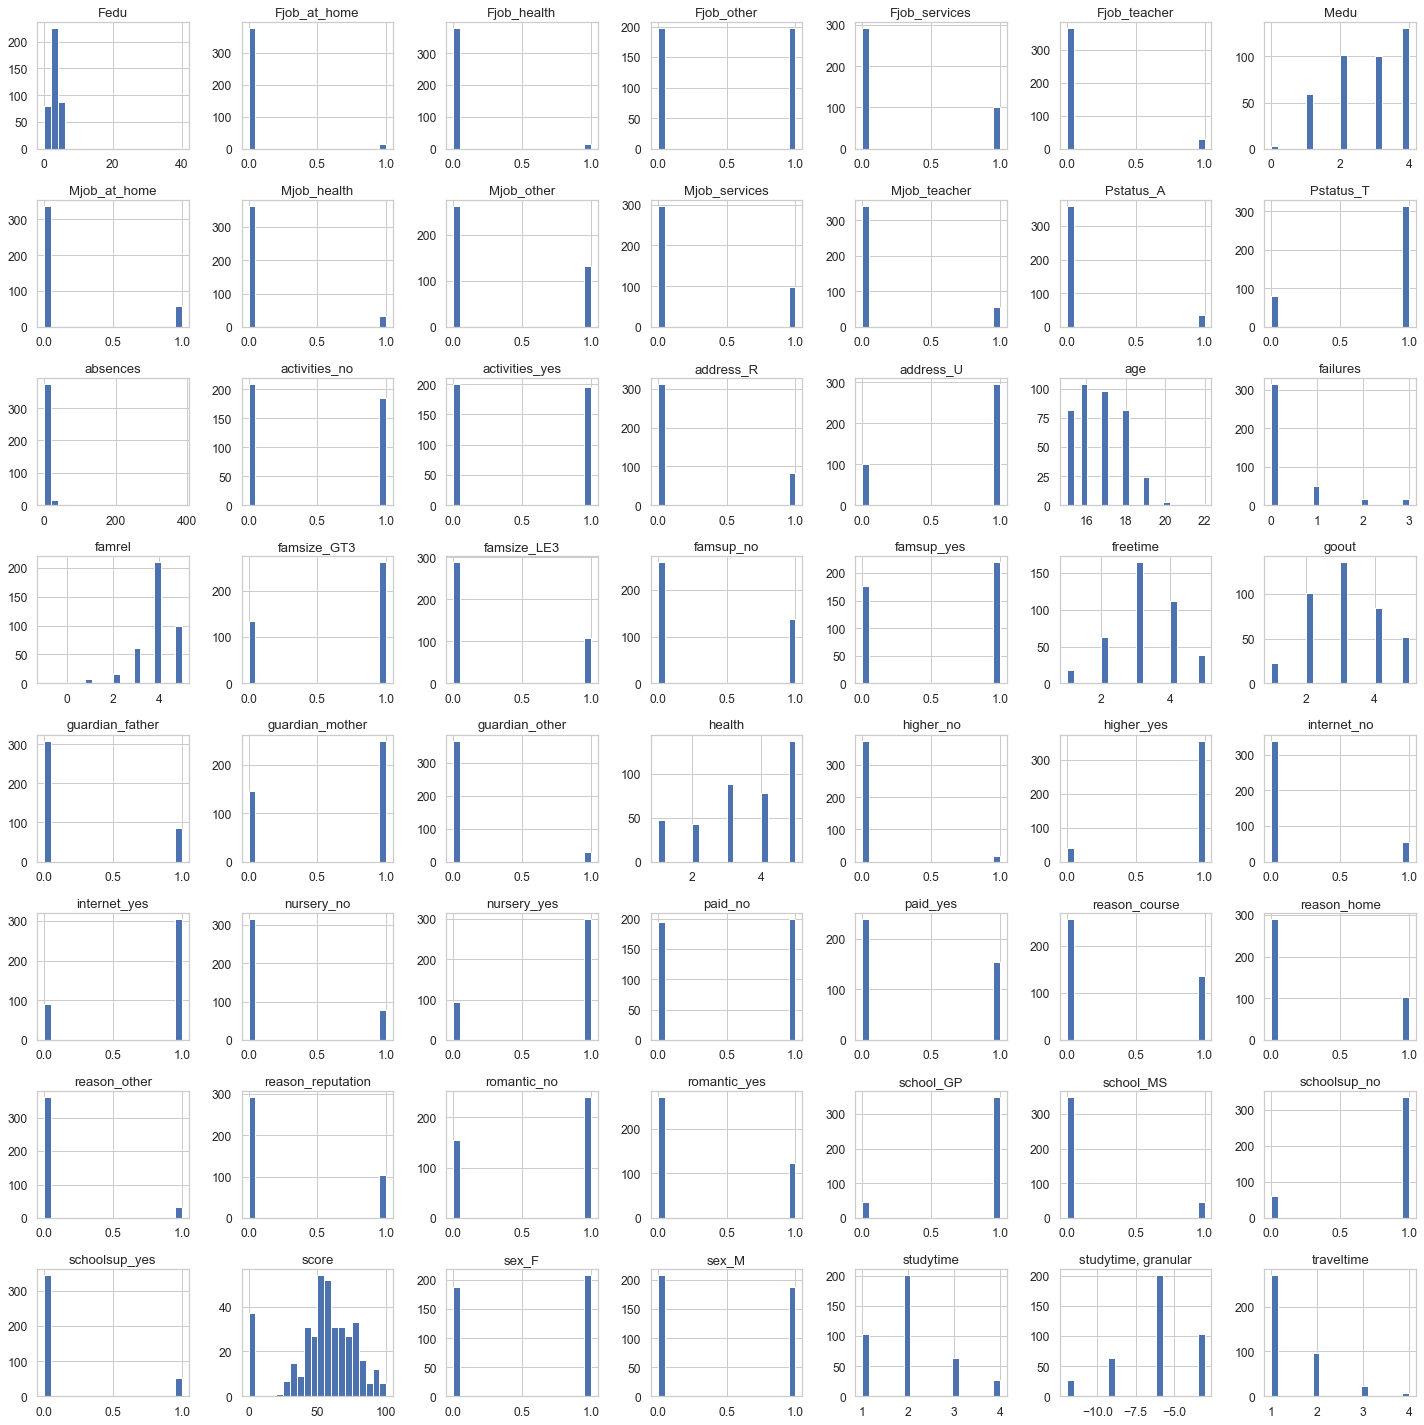

In [19]:
cols = data.columns[~data.columns.str.contains(
    '_nan') & ~data.columns.str.contains('_isNAN')]
data[cols].hist(figsize=(20, 20), bins=20)
plt.tight_layout()
plt.show()

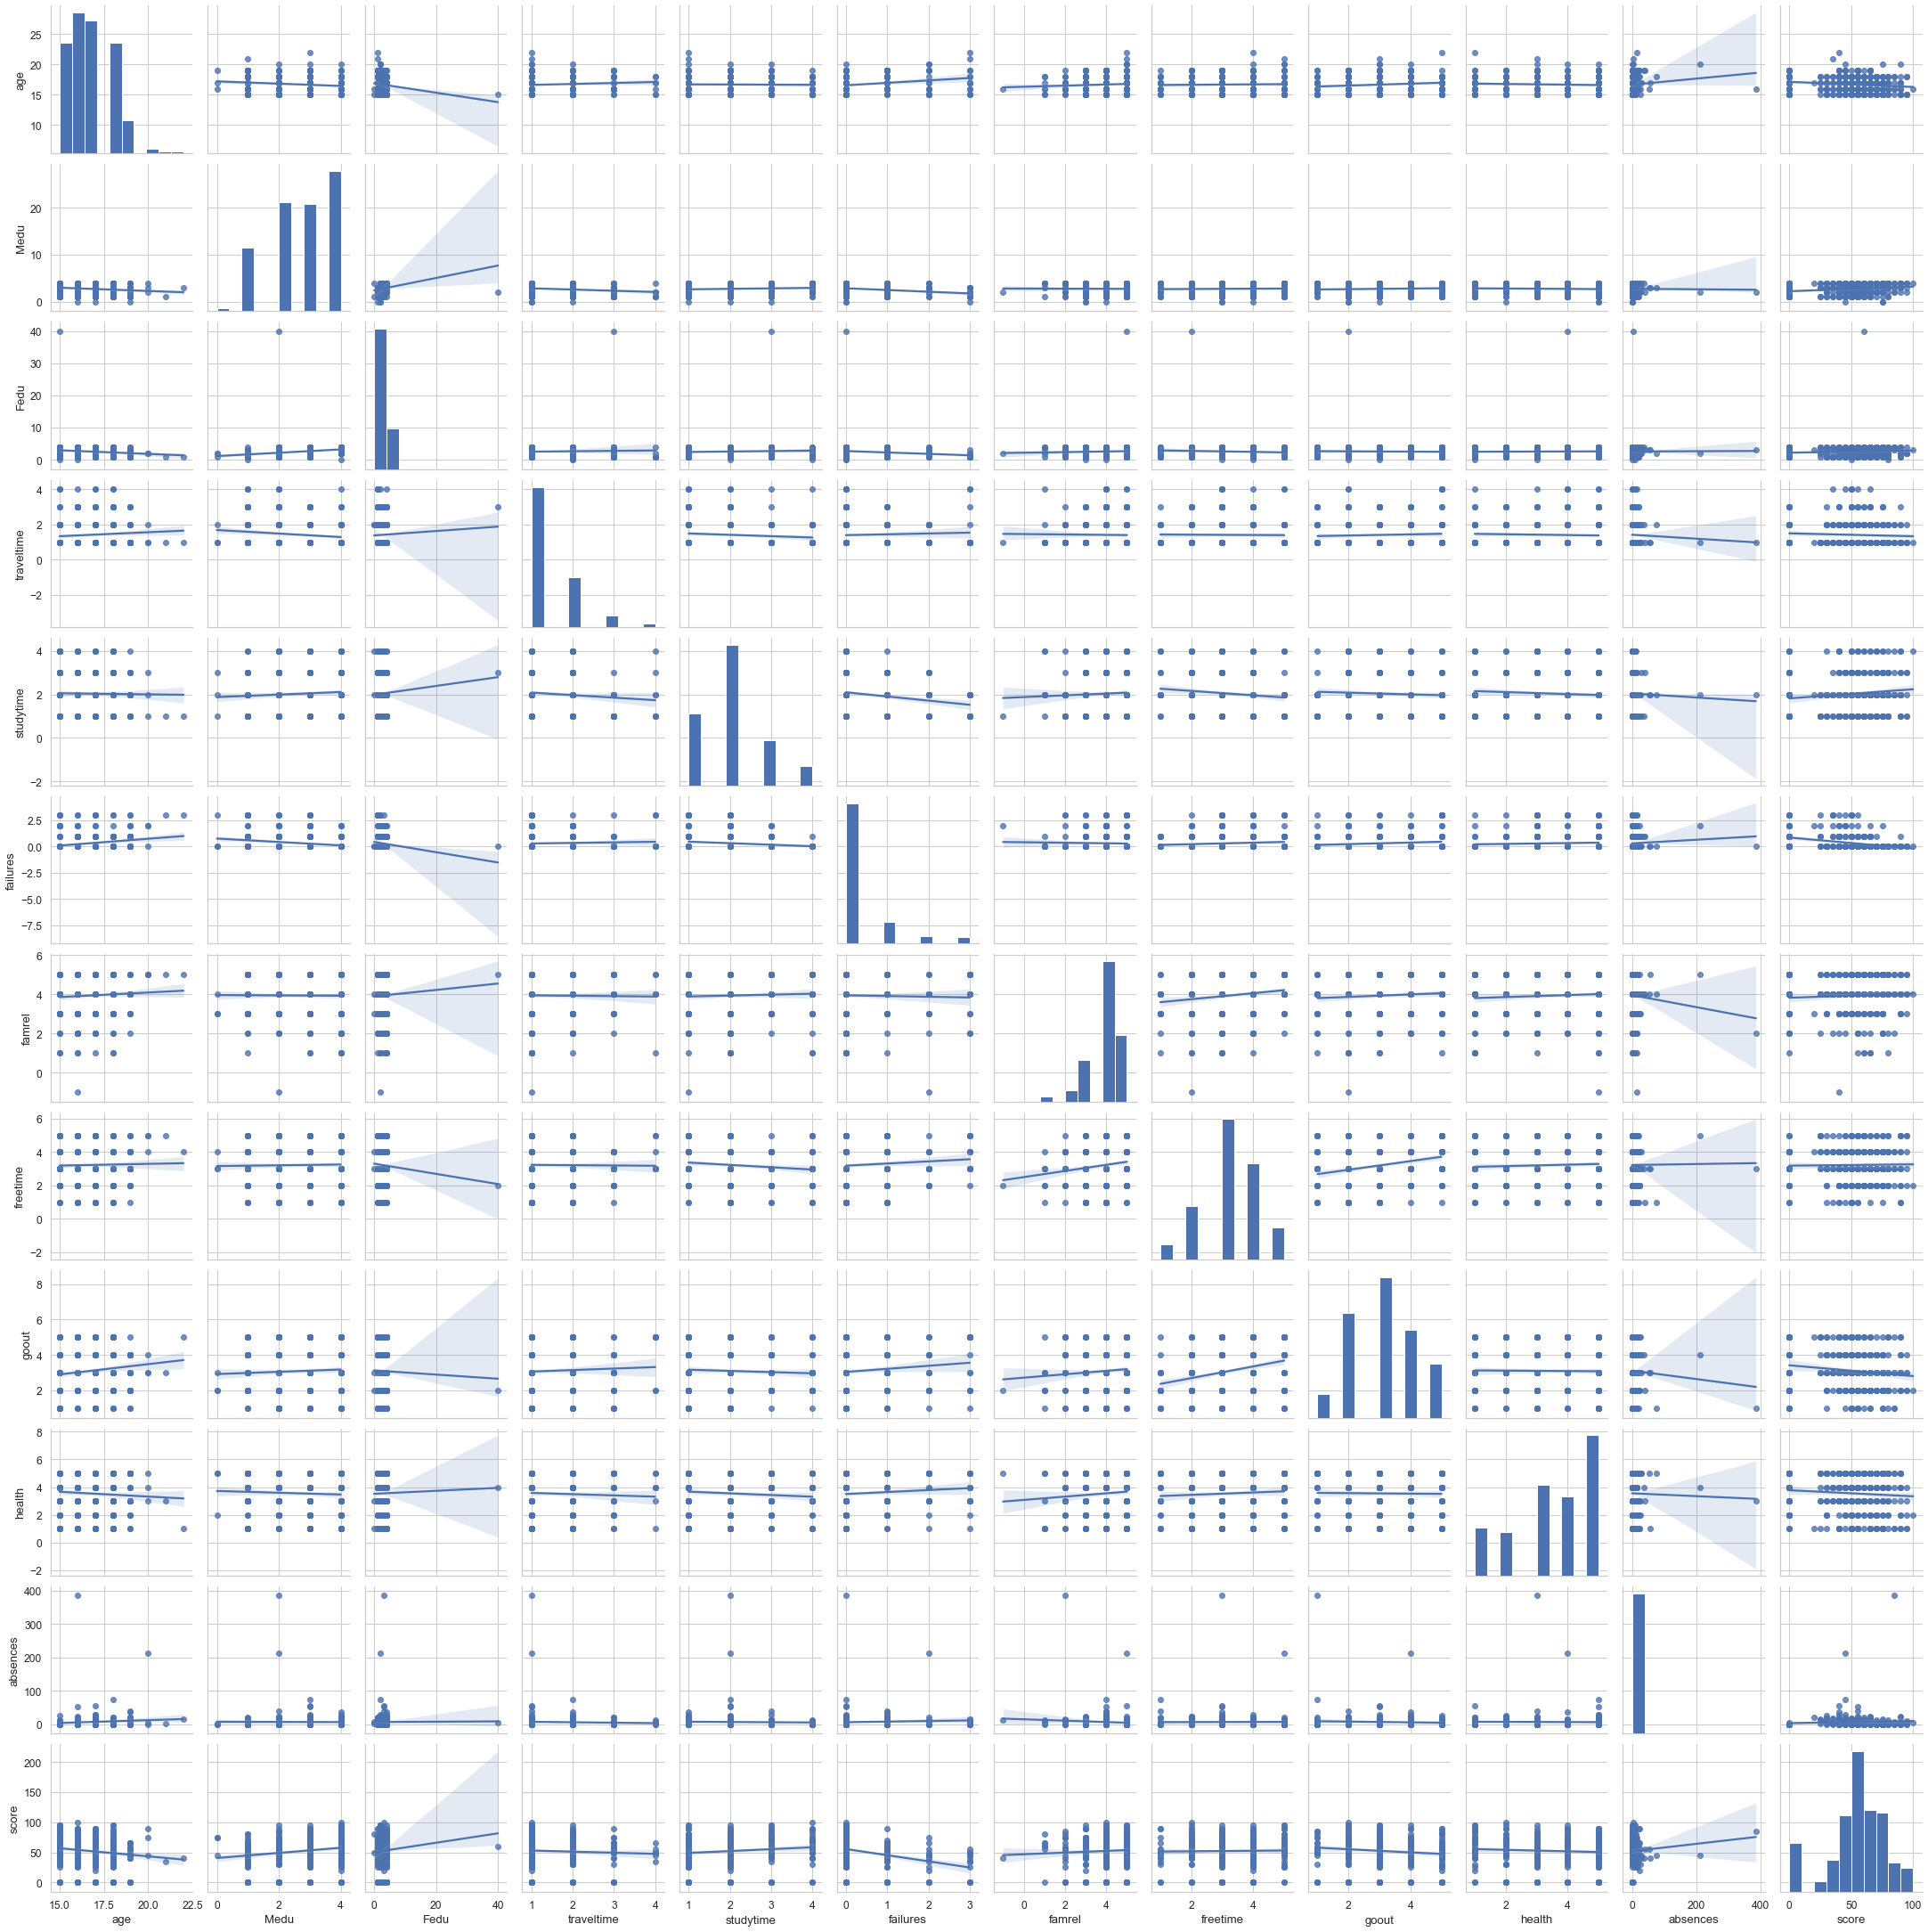

In [97]:
cols = data.columns[~data.columns.str.contains('_')]
sns.pairplot(data[cols], kind='reg')

In [20]:
data.describe()

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score,school_GP,school_MS,school_nan,sex_F,sex_M,sex_nan,address_R,address_U,address_nan,famsize_GT3,famsize_LE3,famsize_nan,Pstatus_A,Pstatus_T,Pstatus_nan,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Mjob_nan,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,Fjob_nan,reason_course,reason_home,reason_other,reason_reputation,reason_nan,guardian_father,guardian_mother,guardian_other,guardian_nan,schoolsup_no,schoolsup_yes,schoolsup_nan,famsup_no,famsup_yes,famsup_nan,paid_no,paid_yes,paid_nan,activities_no,activities_yes,activities_nan,nursery_no,nursery_yes,nursery_nan,higher_no,higher_yes,higher_nan,internet_no,internet_yes,internet_nan,romantic_no,romantic_yes,romantic_nan,Medu_isNAN,Fedu_isNAN,traveltime_isNAN,studytime_isNAN,failures_isNAN,"studytime, granular_isNAN",famrel_isNAN,freetime_isNAN,goout_isNAN,health_isNAN,absences_isNAN,score_isNAN
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.0,395.000000,395.000000,395.0,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.751899,2.577215,1.407595,2.037975,0.318987,-6.113924,3.941772,3.225316,3.103797,3.549367,7.179747,52.303797,0.883544,0.116456,0.0,0.526582,0.473418,0.0,0.210127,0.746835,0.043038,0.660759,0.270886,0.068354,0.091139,0.794937,0.113924,0.146835,0.081013,0.336709,0.248101,0.139241,0.048101,0.040506,0.037975,0.498734,0.258228,0.073418,0.091139,0.346835,0.263291,0.086076,0.260759,0.043038,0.217722,0.632911,0.070886,0.078481,0.848101,0.129114,0.022785,0.346835,0.554430,0.098734,0.506329,0.392405,0.101266,0.470886,0.493671,0.035443,0.200000,0.759494,0.040506,0.048101,0.901266,0.050633,0.141772,0.772152,0.086076,0.607595,0.313924,0.078481,0.007595,0.060759,0.070886,0.017722,0.055696,0.017722,0.068354,0.027848,0.020253,0.037975,0.030380,0.015190
std,1.276043,1.094154,2.164782,0.678490,0.834580,0.726244,2.503740,0.895081,0.980711,1.104610,1.372118,23.111967,22.746314,0.321177,0.321177,0.0,0.499926,0.499926,0.0,0.407915,0.435376,0.203200,0.474052,0.444981,0.252673,0.288172,0.404260,0.318122,0.354391,0.273201,0.473184,0.432459,0.346636,0.214252,0.197394,0.191377,0.500633,0.438215,0.261152,0.288172,0.476566,0.440978,0.280832,0.439606,0.203200,0.413220,0.482622,0.256960,0.269268,0.359378,0.335751,0.149406,0.476566,0.497659,0.298683,0.500594,0.488905,0.302063,0.499785,0.500594,0.185131,0.400507,0.427933,0.197394,0.214252,0.298683,0.219525,0.349259,0.419976,0.280832,0.488905,0.464674,0.269268,0.086927,0.239192,0.256960,0.132105,0.229625,0.132105,0.252673,0.164746,0.141044,0.191377,0.171848,0.122463
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-12.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

## Проверим наличие выбросов

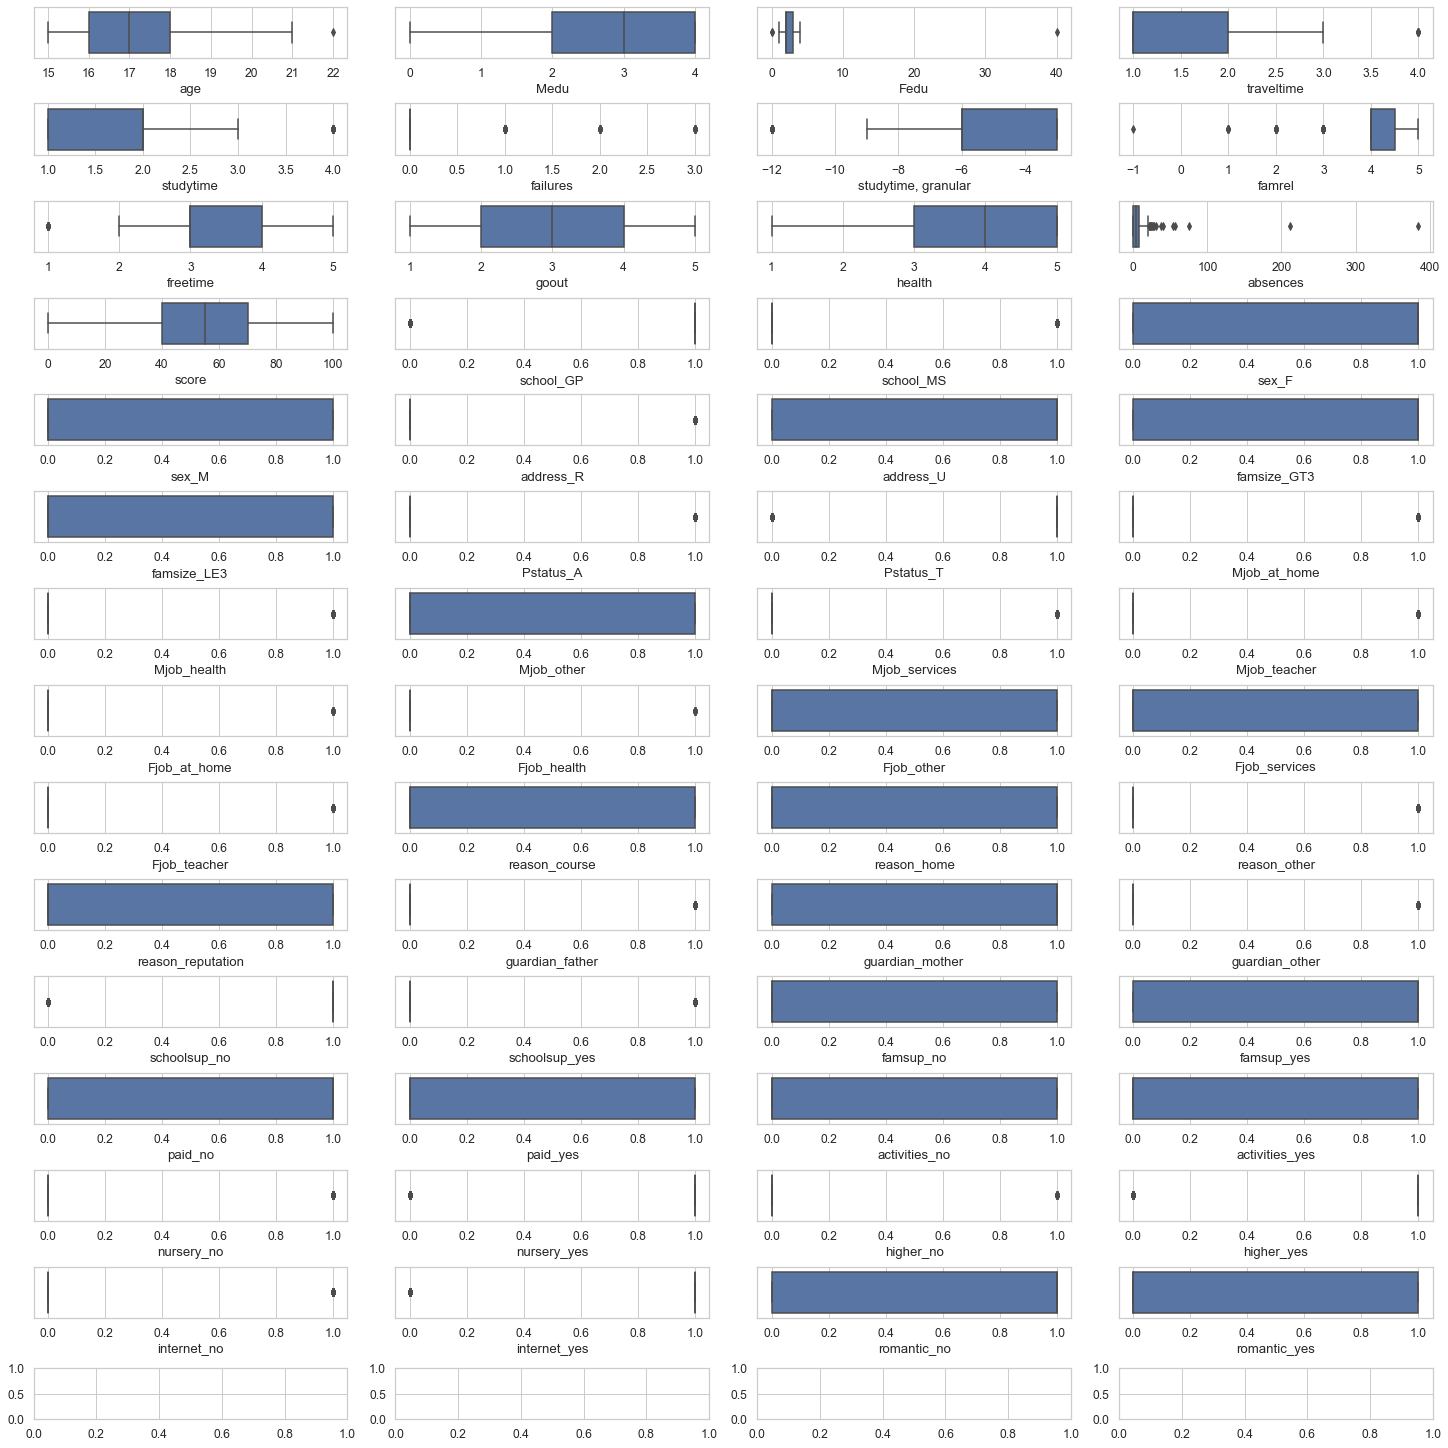

In [21]:
num_plots = len(cols)
total_cols = 4
total_rows = num_plots//total_cols + 1
fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(20, 20), constrained_layout=True)
for i, var in enumerate(cols):
    row = i//total_cols
    pos = i % total_cols
    plot = sns.boxplot(x=var, data=data, ax=axs[row][pos])

In [22]:
# Проведем подсчет выбросов количественных признаков
outliers_cols = []
cols_nums = data.columns[~data.columns.str.contains('_')]
for col in cols_nums:
    bottom, top = get_outliers_border(data[col])
    out_count = data[(data[col] < bottom) | (data[col] > top)].count()[0]
    if out_count > 0:
        print(
            f'Выбросы для признака {col}: {out_count} ({bottom}, {top}). Min: {data[col].min()} Max: {data[col].max()}')
        outliers_cols.append(col)

Выбросы для признака age: 1 (13, 21). Min: 15 Max: 22
Выбросы для признака Fedu: 1 (0, 4). Min: 0.0 Max: 40.0
Выбросы для признака traveltime: 7 (0, 3). Min: 1.0 Max: 4.0
Выбросы для признака studytime: 27 (0, 3). Min: 1.0 Max: 4.0
Выбросы для признака failures: 80 (0, 0). Min: 0.0 Max: 3.0
Выбросы для признака studytime, granular: 27 (-10, 1). Min: -12.0 Max: -3.0
Выбросы для признака famrel: 25 (3, 5). Min: -1.0 Max: 5.0
Выбросы для признака absences: 17 (-12, 20). Min: 0.0 Max: 385.0


### Проведем анализ выбросов 
**age** — возраст ученика (от **15** до **22**);<br>
**f_edu** — образование отца (**0** - нет, **1** - 4 класса, **2** - 5-9 классы,
    **3** - среднее специальное или 11 классов, **4** - высшее);<br>
**traveltime** — время в пути до школы (**1** - <15 мин., **2** - 15-30 мин., 
    **3** - 30-60 мин., **4** - >60 мин.);<br>
**studytime** — время на учёбу помимо школы в неделю (**1** - <2 часов, **2** - 2-5 часов, 
    **3** - 5-10 часов, **4** - >10 часов);<br>
**failures** — количество внеучебных неудач (**n**, если 1<=n<3, иначе **4**);<br>
**studytime_granular** - неизвестная колонка, необходимо понять, с чем она коррелирует<br>
**famrel** — семейные отношения (от **1** - очень плохо до **5** - очень хорошо);<br>
**absences** — количество пропущенных занятий;

In [23]:
# Установим границы для данных согласно описания
outliers_borders = [(15, 22), (0, 4), (1, 4), (1, 4),
                    (0, 3), (-10, 1), (1, 5), (0, 30)]
outliers_count = []
for i, col in enumerate(outliers_cols):
    bottom, top = get_outliers_border(
        data[col], outliers_borders[i][0], outliers_borders[i][1], True)
    out_count = data[(data[col] < bottom) | (data[col] > top)].count()[0]
    if out_count > 0:
        print(
            f'Выбросы для признака {col}: {out_count} ({bottom}, {top}). Min: {data[col].min()} Max: {data[col].max()}')
        outliers_count.append(out_count)
print(f'Всего обнаружено выбросов: {sum(outliers_count)}')

Выбросы для признака Fedu: 1 (0, 4). Min: 0.0 Max: 40.0
Выбросы для признака studytime, granular: 27 (-10, 1). Min: -12.0 Max: -3.0
Выбросы для признака famrel: 1 (1, 5). Min: -1.0 Max: 5.0
Выбросы для признака absences: 7 (0, 30). Min: 0.0 Max: 385.0
Всего обнаружено выбросов: 36


Теперь видим, что выбросов не так много и можно аккуратно почистить от них данные.

## Корреляция признаков

Корреляция целевой переменной с признаками

In [83]:
data.corr()['score'].sort_values(ascending=False)

score                1.000000
Medu                 0.205568
studytime            0.114371
higher_yes           0.110149
Mjob_health          0.108754
sex_M                0.098026
paid_yes             0.095379
Fjob_teacher         0.093225
studytime_isNAN      0.087736
reason_reputation    0.086987
Fedu                 0.074467
internet_yes         0.068372
absences             0.062383
Mjob_services        0.061725
absences_isNAN       0.056720
famrel               0.055223
famsup_nan           0.054226
nursery_yes          0.053156
Mjob_teacher         0.050954
failures_isNAN       0.050690
reason_other         0.048343
Pstatus_A            0.039519
freetime_isNAN       0.037020
address_nan          0.036152
higher_nan           0.029950
Fjob_nan             0.029839
Fjob_health          0.029411
Mjob_nan             0.029283
guardian_father      0.026159
Pstatus_nan          0.023265
guardian_mother      0.018276
freetime             0.018200
activities_yes       0.018001
score_isNA

### Построим тепловую карту корреляции

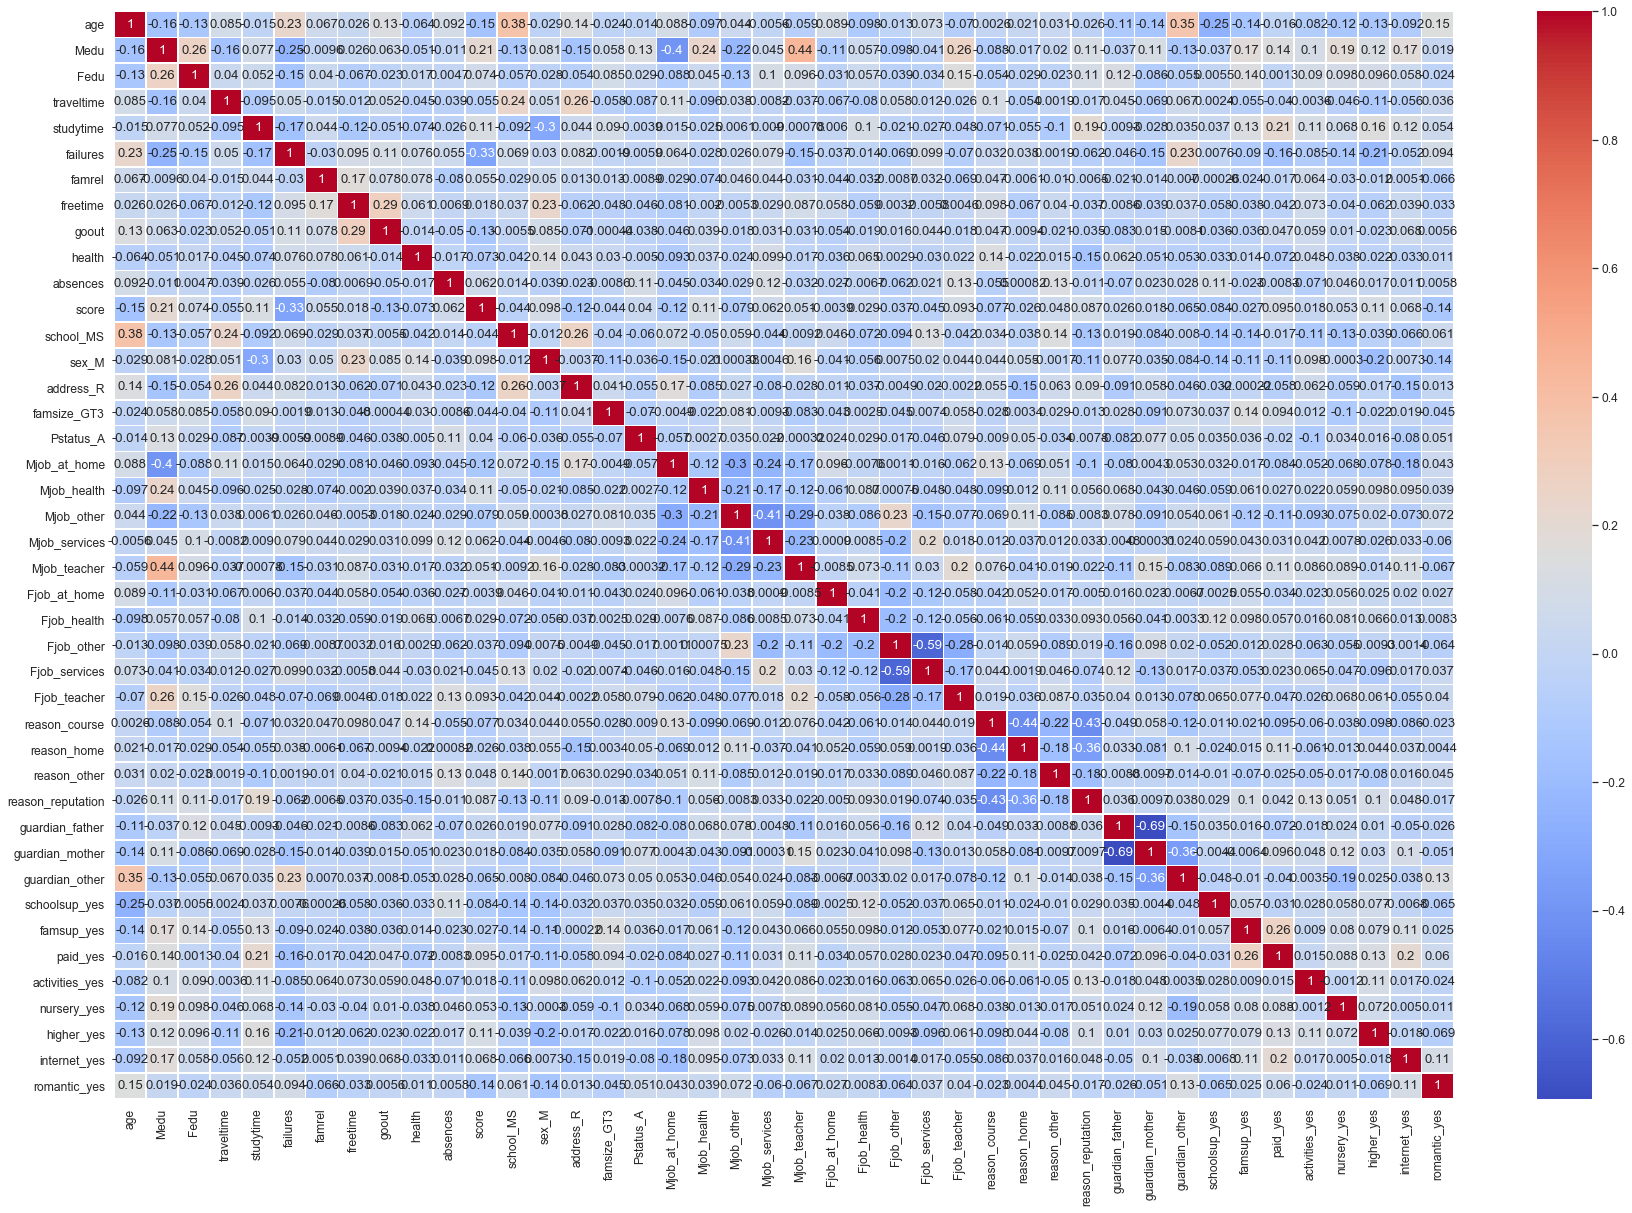

In [93]:
pd.set_option('display.max_rows', None)
plt.figure(figsize=(30, 20))


sns.heatmap(data[data.columns[~(data.columns.str.contains('_nan')) & ~(
    data.columns.str.contains('_isNAN'))]].corr(), annot=True, linewidths=.5, cmap='coolwarm')

In [95]:
# Корреляция признаков между собой
for col in data.columns:
    print('-------------------------------')
    print(f'Корреляция для признака {col}')
    print('-------------------------------')
    corr = data.corr()[col]
    print(corr[(corr <= -0.5) | (corr >= 0.5)])

-------------------------------
Корреляция для признака age
-------------------------------
age    1.0
Name: age, dtype: float64
-------------------------------
Корреляция для признака Medu
-------------------------------
Medu    1.0
Name: Medu, dtype: float64
-------------------------------
Корреляция для признака Fedu
-------------------------------
Fedu    1.0
Name: Fedu, dtype: float64
-------------------------------
Корреляция для признака traveltime
-------------------------------
traveltime    1.0
Name: traveltime, dtype: float64
-------------------------------
Корреляция для признака studytime
-------------------------------
studytime    1.0
Name: studytime, dtype: float64
-------------------------------
Корреляция для признака failures
-------------------------------
failures    1.0
Name: failures, dtype: float64
-------------------------------
Корреляция для признака famrel
-------------------------------
famrel    1.0
Name: famrel, dtype: float64
----------------------------

Видно, что колонка <b>studytime_granular</b> имеет полную отрицательную корреляцию с <b>studytime</b> и может быть исключена из данных.
Все категориальные признаки с вариантами <b>Yes/No</b> после разделения через <b>get_dummies</b> имеют сильную корреляцию между собой и можно оставить только один из вариантов.<p>
    Самое большое положительное влияние на целевую переменную <b>score</b> оказывает образование матери (Medu), а самое негативное - неудачи (<b>failures</b>).

# Распределение признаков относительно целевой переменной

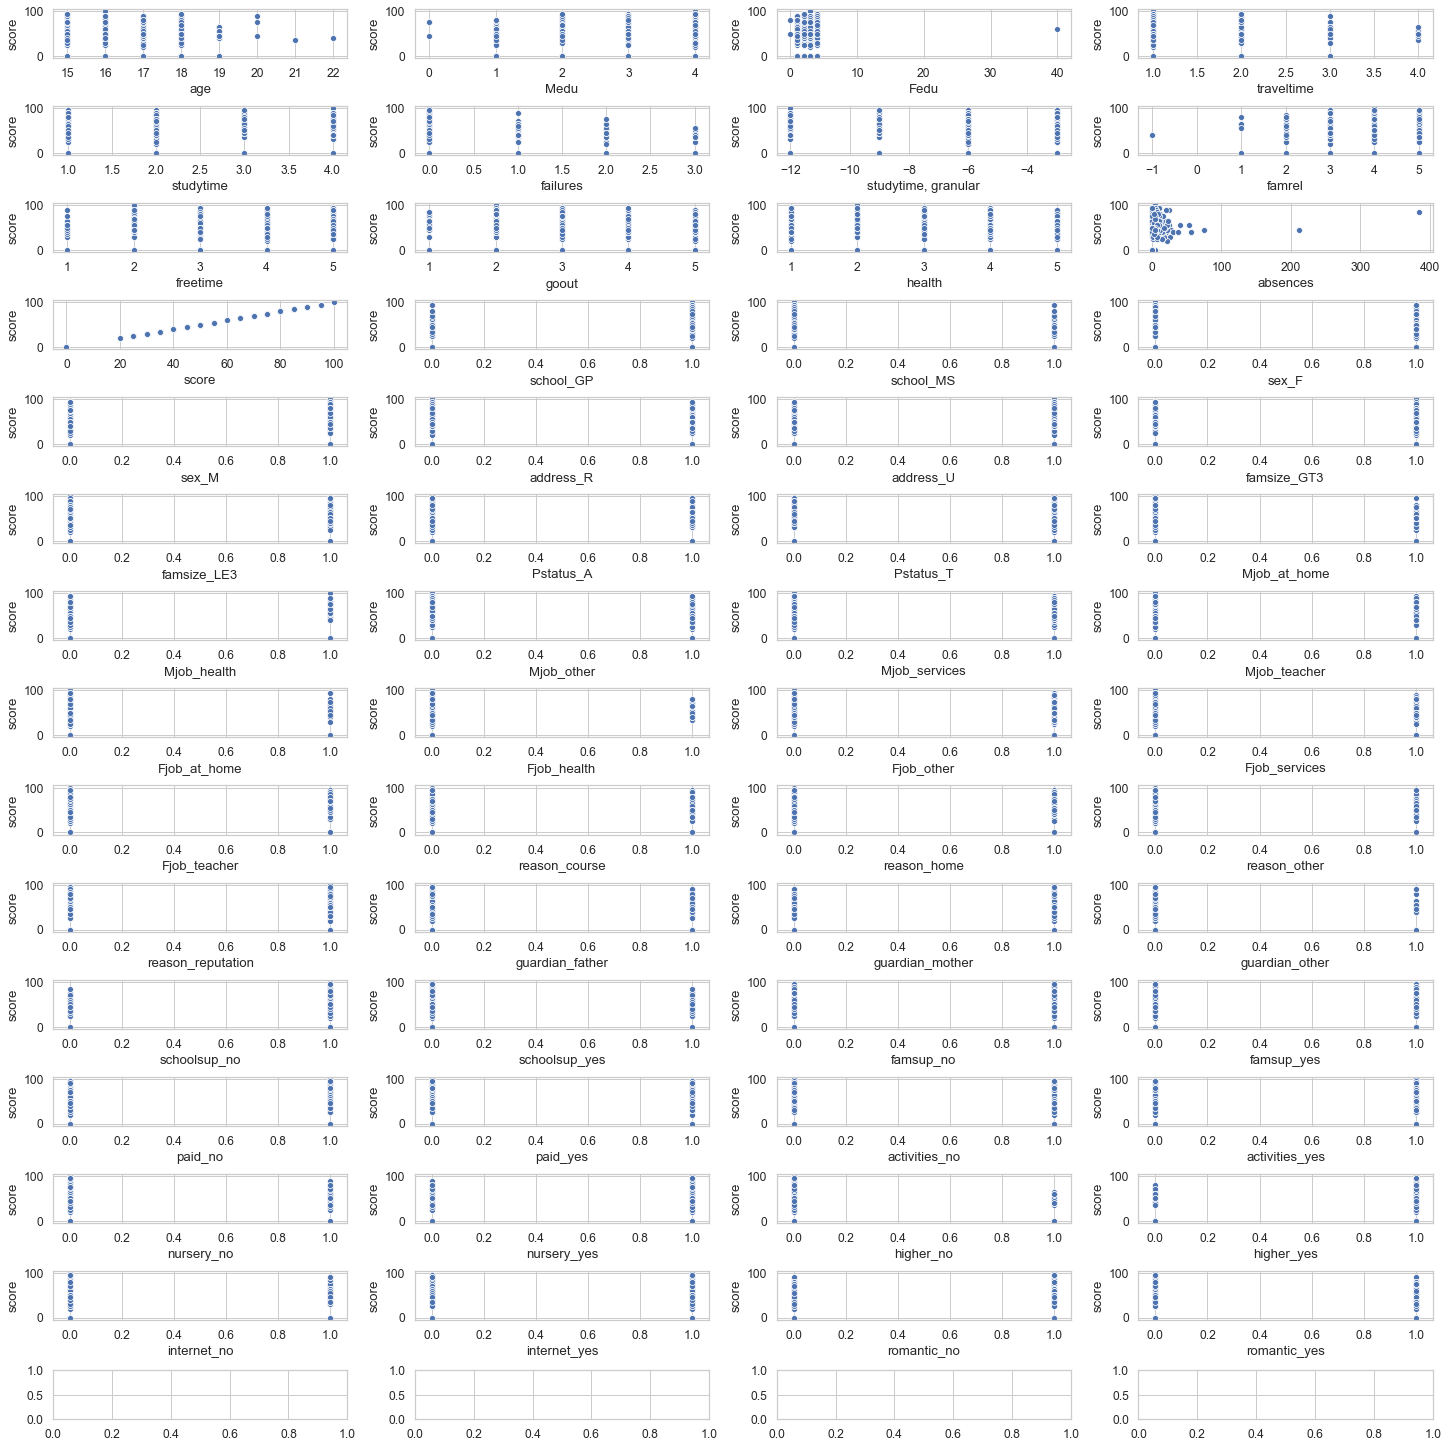

In [27]:
num_plots = len(cols)
total_cols = 4
total_rows = num_plots//total_cols + 1
fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(20, 20), constrained_layout=True)
for i, var in enumerate(cols):
    row = i//total_cols
    pos = i % total_cols
    plot = sns.scatterplot(x=var, y=data.score, data=data, ax=axs[row][pos])

## Отберем признаки для построения модели
Для построения нашей модели мы должны избавиться от сильно коррелирующих между собой признаков.

In [28]:
data.drop(['studytime, granular', 'studytime, granular_isNAN', 'address_U',
           'famsize_LE3', 'Pstatus_T', 'sex_F', 'school_GP'], inplace=True, axis=1)
model_cols = data.columns[data.columns.str.contains('_no')]
data.drop(model_cols, inplace=True, axis=1)

In [29]:
# Количество признаков для построяния модели
print(data.columns, len(data.columns))

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score', 'school_MS',
       'school_nan', 'sex_M', 'sex_nan', 'address_R', 'address_nan',
       'famsize_GT3', 'famsize_nan', 'Pstatus_A', 'Pstatus_nan',
       'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services',
       'Mjob_teacher', 'Mjob_nan', 'Fjob_at_home', 'Fjob_health', 'Fjob_other',
       'Fjob_services', 'Fjob_teacher', 'Fjob_nan', 'reason_course',
       'reason_home', 'reason_other', 'reason_reputation', 'reason_nan',
       'guardian_father', 'guardian_mother', 'guardian_other', 'guardian_nan',
       'schoolsup_yes', 'schoolsup_nan', 'famsup_yes', 'famsup_nan',
       'paid_yes', 'paid_nan', 'activities_yes', 'activities_nan',
       'nursery_yes', 'nursery_nan', 'higher_yes', 'higher_nan',
       'internet_yes', 'internet_nan', 'romantic_yes', 'romantic_nan',
       'Medu_isNAN', 'Fedu_isNAN', 'traveltime_isNAN', 'studytime_isNAN',

## Выводы

<font size=3>
1. Данные имеют 17 категориальных признаков, которые требуют предварительной обработки для проведения анализа. Такую обработку выполняем при помощи функции get_dummies с параметром dummy_na=True, чтобы вынести пропуски в отдельный признак.<br>
2. Видно, что в целом, целевая переменная распределена нормально с некоторыми значениями в нуле. Сделаем предположение, что данные студенты по каким-то причинам не учавствовали в экзамене.<br>
3. Колонка <b>studytime_granular</b> имеет полную отрицательную корреляцию с <b>studytime</b> и может быть исключена из данных.
Все категориальные признаки с вариантами <b>Yes/No</b> после разделения через <b>get_dummies</b> имеют сильную корреляцию между собой и можно оставить только один из вариантов.<br>
4. Самая высокая корреляция с целевой переменной <b>score</b> у образования матери (Medu), а самая низкая - неудачи (<b>failures</b>). Также видно, что пропуски занятий (absenses) тесно связаны с целевой переменной - чем меньше пропусков тем выше оценка.<br>
5. Данные имеют достаточно большое количество пропусков - 565. Необходимо заполнить пропуски, например, средним значением или медианой. В этом примере я заполнил средним значением.<br>
6. При помощи межквартильного размаха обнаружено 36 выбросов.<br>
7. Для построяния модели я отобрал 70 признаков. Были удалены признаки с суфиксом _no и признаки ['studytime, granular', 'studytime, granular_isNAN', 'address_U', 'famsize_LE3', 'Pstatus_T', 'sex_F', 'school_GP'].<p>
    
<b>Для построения модели будем использовать следующие признаки:</b><br>
['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score', 'school_MS',
       'school_nan', 'sex_M', 'sex_nan', 'address_R', 'address_nan',
       'famsize_GT3', 'famsize_nan', 'Pstatus_A', 'Pstatus_nan',
       'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services',
       'Mjob_teacher', 'Mjob_nan', 'Fjob_at_home', 'Fjob_health', 'Fjob_other',
       'Fjob_services', 'Fjob_teacher', 'Fjob_nan', 'reason_course',
       'reason_home', 'reason_other', 'reason_reputation', 'reason_nan',
       'guardian_father', 'guardian_mother', 'guardian_other', 'guardian_nan',
       'schoolsup_yes', 'schoolsup_nan', 'famsup_yes', 'famsup_nan',
       'paid_yes', 'paid_nan', 'activities_yes', 'activities_nan',
       'nursery_yes', 'nursery_nan', 'higher_yes', 'higher_nan',
       'internet_yes', 'internet_nan', 'romantic_yes', 'romantic_nan',
       'Medu_isNAN', 'Fedu_isNAN', 'traveltime_isNAN', 'studytime_isNAN',
       'failures_isNAN', 'famrel_isNAN', 'freetime_isNAN', 'goout_isNAN',
       'health_isNAN', 'absences_isNAN', 'score_isNAN']


</font>

# Bonus!
Если Хотите построить модель на основе отобранных признаков то можете продолжить далее. Этот материал забегает немного вперед, но зато позволит лучше понять зачем этот EDA вообще нужно было делать)

# 2. Подготовка данных для модели
Для того чтоб наша модель могла работать с нашими признаки они должны быть в цифровом формате понятной машине (в форматах int или float и без None-значений).

### 2.1. Обработка категориальных признаков

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [30]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
# Тут я возьму в обработку все object признаки.
object_columns = [s for s in data_ml.columns if data_ml[s].dtypes == 'object']
data_ml = pd.get_dummies(data_ml, columns=object_columns, dummy_na=True)

In [31]:
data_ml.head(5)

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score,school_GP,school_MS,school_nan,sex_F,sex_M,sex_nan,address_R,address_U,address_nan,famsize_GT3,famsize_LE3,famsize_nan,Pstatus_A,Pstatus_T,Pstatus_nan,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Mjob_nan,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,Fjob_nan,reason_course,reason_home,reason_other,reason_reputation,reason_nan,guardian_father,guardian_mother,guardian_other,guardian_nan,schoolsup_no,schoolsup_yes,schoolsup_nan,famsup_no,famsup_yes,famsup_nan,paid_no,paid_yes,paid_nan,activities_no,activities_yes,activities_nan,nursery_no,nursery_yes,nursery_nan,higher_no,higher_yes,higher_nan,internet_no,internet_yes,internet_nan,romantic_no,romantic_yes,romantic_nan
0,18,4.0,4.0,2.0,2.0,0.0,-6.0,4.0,3.0,4.0,3.0,6.0,30.0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0,0
1,17,1.0,1.0,1.0,2.0,0.0,-6.0,5.0,3.0,3.0,3.0,4.0,30.0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0
2,15,1.0,1.0,1.0,2.0,3.0,-6.0,4.0,3.0,2.0,3.0,10.0,50.0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1
3,15,4.0,2.0,1.0,3.0,0.0,-9.0,3.0,2.0,2.0,5.0,2.0,75.0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0
4,16,3.0,3.0,1.0,2.0,0.0,-6.0,4.0,3.0,2.0,5.0,4.0,50.0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0


In [32]:
data_ml.sample(5)

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score,school_GP,school_MS,school_nan,sex_F,sex_M,sex_nan,address_R,address_U,address_nan,famsize_GT3,famsize_LE3,famsize_nan,Pstatus_A,Pstatus_T,Pstatus_nan,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Mjob_nan,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,Fjob_nan,reason_course,reason_home,reason_other,reason_reputation,reason_nan,guardian_father,guardian_mother,guardian_other,guardian_nan,schoolsup_no,schoolsup_yes,schoolsup_nan,famsup_no,famsup_yes,famsup_nan,paid_no,paid_yes,paid_nan,activities_no,activities_yes,activities_nan,nursery_no,nursery_yes,nursery_nan,higher_no,higher_yes,higher_nan,internet_no,internet_yes,internet_nan,romantic_no,romantic_yes,romantic_nan
213,18,2.0,2.0,1.0,2.0,1.0,-6.0,4.0,4.0,4.0,5.0,15.0,40.0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
10,15,4.0,4.0,1.0,2.0,0.0,-6.0,3.0,3.0,3.0,2.0,0.0,45.0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0
52,15,4.0,2.0,2.0,1.0,1.0,-3.0,5.0,5.0,5.0,5.0,6.0,50.0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0,0
298,18,4.0,3.0,1.0,4.0,0.0,-12.0,4.0,3.0,3.0,3.0,0.0,70.0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0
40,16,2.0,2.0,2.0,2.0,1.0,-6.0,3.0,3.0,3.0,3.0,25.0,55.0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0


### 2.2. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

### Данные были предварительно обработаны в EDA.

In [33]:
# в этом примере я заполняю пропуски median-ой, попробуйте другие подходы
nan_columns = list(data_ml.columns[data_ml.isnull().sum() > 0])
if nan_columns:
    for nan_column in nan_columns:
        data_ml[nan_column +
                '_isNAN'] = pd.isna(data_ml[nan_column]).astype('uint8')
    data_ml.fillna(data_ml.median(), inplace=True)

In [34]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 85 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        395 non-null    int64  
 1   Medu                       395 non-null    float64
 2   Fedu                       395 non-null    float64
 3   traveltime                 395 non-null    float64
 4   studytime                  395 non-null    float64
 5   failures                   395 non-null    float64
 6   studytime, granular        395 non-null    float64
 7   famrel                     395 non-null    float64
 8   freetime                   395 non-null    float64
 9   goout                      395 non-null    float64
 10  health                     395 non-null    float64
 11  absences                   395 non-null    float64
 12  score                      395 non-null    float64
 13  school_GP                  395 non-null    uint8  

### Удалим выбросы

In [35]:
data_ml = data_ml[(data_ml.absences <= 30) & (
    data_ml.famrel >= 0) & (data_ml.Fedu <= 4)]

### Удалим лишние признаки

In [36]:
data_ml.drop(['studytime, granular', 'studytime, granular_isNAN', 'address_U',
              'famsize_LE3', 'Pstatus_T', 'sex_F', 'school_GP'], inplace=True, axis=1)
model_cols = data_ml.columns[data_ml.columns.str.contains('_no')]
data_ml.drop(model_cols, inplace=True, axis=1)

### Итого

In [37]:
data_ml.head(5)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score,school_MS,school_nan,sex_M,sex_nan,address_R,address_nan,famsize_GT3,famsize_nan,Pstatus_A,Pstatus_nan,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Mjob_nan,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,Fjob_nan,reason_course,reason_home,reason_other,reason_reputation,reason_nan,guardian_father,guardian_mother,guardian_other,guardian_nan,schoolsup_yes,schoolsup_nan,famsup_yes,famsup_nan,paid_yes,paid_nan,activities_yes,activities_nan,nursery_yes,nursery_nan,higher_yes,higher_nan,internet_yes,internet_nan,romantic_yes,romantic_nan,Medu_isNAN,Fedu_isNAN,traveltime_isNAN,studytime_isNAN,failures_isNAN,famrel_isNAN,freetime_isNAN,goout_isNAN,health_isNAN,absences_isNAN,score_isNAN
0,18,4.0,4.0,2.0,2.0,0.0,4.0,3.0,4.0,3.0,6.0,30.0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,17,1.0,1.0,1.0,2.0,0.0,5.0,3.0,3.0,3.0,4.0,30.0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,15,1.0,1.0,1.0,2.0,3.0,4.0,3.0,2.0,3.0,10.0,50.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,15,4.0,2.0,1.0,3.0,0.0,3.0,2.0,2.0,5.0,2.0,75.0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,16,3.0,3.0,1.0,2.0,0.0,4.0,3.0,2.0,5.0,4.0,50.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386 entries, 0 to 394
Data columns (total 70 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                386 non-null    int64  
 1   Medu               386 non-null    float64
 2   Fedu               386 non-null    float64
 3   traveltime         386 non-null    float64
 4   studytime          386 non-null    float64
 5   failures           386 non-null    float64
 6   famrel             386 non-null    float64
 7   freetime           386 non-null    float64
 8   goout              386 non-null    float64
 9   health             386 non-null    float64
 10  absences           386 non-null    float64
 11  score              386 non-null    float64
 12  school_MS          386 non-null    uint8  
 13  school_nan         386 non-null    uint8  
 14  sex_M              386 non-null    uint8  
 15  sex_nan            386 non-null    uint8  
 16  address_R          386 non

Пропуск нет, все признаки в цифровом виде - данные готовы к работе с моделью

### 2.3 Split Data
чтоб сделать оценку на сколько хороша наша модель, сделаем разбивку данных на обучение и тест

In [39]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(data_ml.drop(['score'], axis=1),
                                                    data_ml.score,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)

In [40]:
# проверяем
data_ml.shape, X_train.shape, X_test.shape

((386, 70), (308, 69), (78, 69))

# 3. Model 

In [41]:
# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  # инструменты для оценки точности модели
# Тюнинг модели
from sklearn.model_selection import RandomizedSearchCV

In [42]:
# Тюнинг модели
# Количество деревьев в лесу
n_estimators = [int(x) for x in np.linspace(start=200, stop=500, num=10)]
# Число фич на каждом сплите
max_features = ['auto', 'sqrt']
# Максимальная глубина дерева
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)

# Минимальное число сэмплов для сплита
min_samples_split = [2, 5, 10]
# Минимальное число сэмплов на каждом листе
min_samples_leaf = [1, 2, 4]
# Метод выбора данных для обучения деревьев
bootstrap = [True, False]
# Создаем случайные параметры для модели
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [110]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                               n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)

In [111]:
# Обучаем модель
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   17.3s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [114]:
# Выбираем модель с лучшими параметрами
model = rf_random.best_estimator_

In [115]:
# Обучаем модель
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [116]:
# Предсказываем целевую переменную на тестовой выборке
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [117]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
# Чем меньше - тем лучше
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('Model SCORE:', model.score(X_test, y_test))

MAE: 14.949525043410713
Model SCORE: 0.22779305728443833


### Важность признаков для принятия решений деревьями

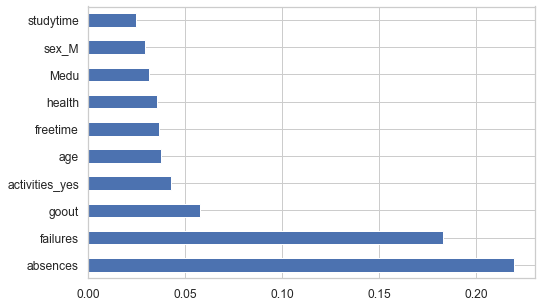

In [118]:
feat_importances = pd.Series(
    model.feature_importances_, index=data_ml.drop(['score'], axis=1).columns)
feat_importances.nlargest(10).plot(kind='barh')

## Построим график остатков

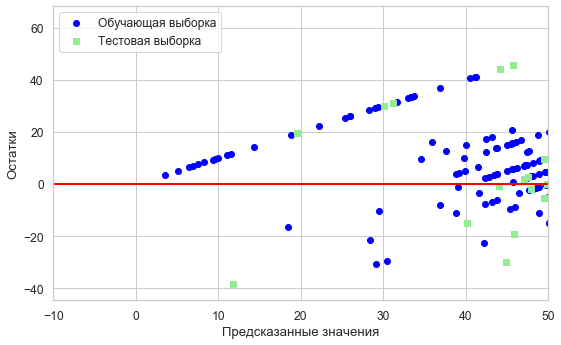

In [119]:
plt.scatter(y_pred_train,  y_pred_train - y_train,
            c='blue', marker='o', label='Обучающая выборка')
plt.scatter(y_pred,  y_pred - y_test,
            c='lightgreen', marker='s', label='Тестовая выборка')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()

# А зачем тут EDA?
Большинство последних соревнований по ML было выиграно благодаря глубокому понимаюнию самих данных и Подробному EDA! Чем лучше вы понимание сами признаки и что за ними стоит, тем проще вам будет ими манипулировать и генерировать новые сильные признаки.

Теперь на основе EDA попробуем это сделать сами:
* Удалите лишние по вашему мнению признаки
* Попробуйте по другому обработать пропуски и выбросы
* Попробуйте извлечь дополнительные признаки 
* Посмотрите какие могут быть глубокие взаимосвязи между признаками и таргетом, и как можно помочь модели их увидеть. 

Посмотрите как это влияет на результат модели...    
Поделитесь своими результатами и идеями с коллегами в Slacke